In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2



In [2]:
# load the dataset ( a numpy array ) 
def load_olivetti_faces(dataset_path):
    images = np.load(dataset_path)
    return images

In [3]:
# resize and flatten the image
def preprocess_images(images, target_size=(64, 64)):
    resized_images = [cv2.resize(img, target_size) for img in images]
    flattened_images = [img.flatten() for img in resized_images]
    return np.array(flattened_images)

In [4]:
# averaging along the rows of the images array
def calculate_mean_face(images):
    return np.mean(images, axis=0)

In [5]:
# mean_face a 1D array representing the average intensity values for each pixel position across all images
def calculate_covariance_matrix(images):
    mean_face = calculate_mean_face(images)
    centered_images = images - mean_face
    # transposes the centered_images array
    covariance_matrix = np.cov(centered_images.T)
    return covariance_matrix

In [6]:
# perform eigen decomposition on the covariance matrix and sort the eigenvalues and eigenvectors
def perform_eigen_decomposition(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

In [7]:
# select the top num_components eigenvectors, which are the eigenfaces
def compute_eigenfaces(eigenvectors, num_components):
    return eigenvectors[:, :num_components]

In [8]:
# project the images onto the eigenfaces
def project_images(images, eigenfaces):
    return np.dot(images, eigenfaces)

In [9]:
# reconstruct the images from their projections onto the eigenfaces
def reconstruct_images(projection, eigenfaces, mean_face):
    return np.dot(projection, eigenfaces.T) + mean_face

In [10]:
def components_for_variance(eigenvalues, variance_threshold):
    cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return num_components

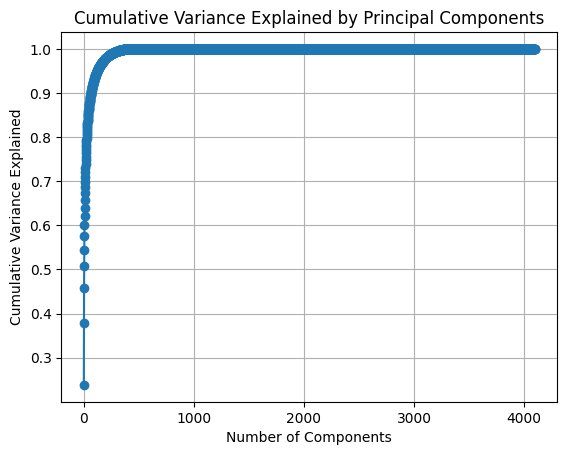

Variance Threshold: 50.0% - Number of Components: 4 - Actual Variance: 50.77%
Variance Threshold: 75.0% - Number of Components: 19 - Actual Variance: 75.59%
Variance Threshold: 90.0% - Number of Components: 66 - Actual Variance: 90.02%
Variance Threshold: 95.0% - Number of Components: 123 - Actual Variance: 95.04%


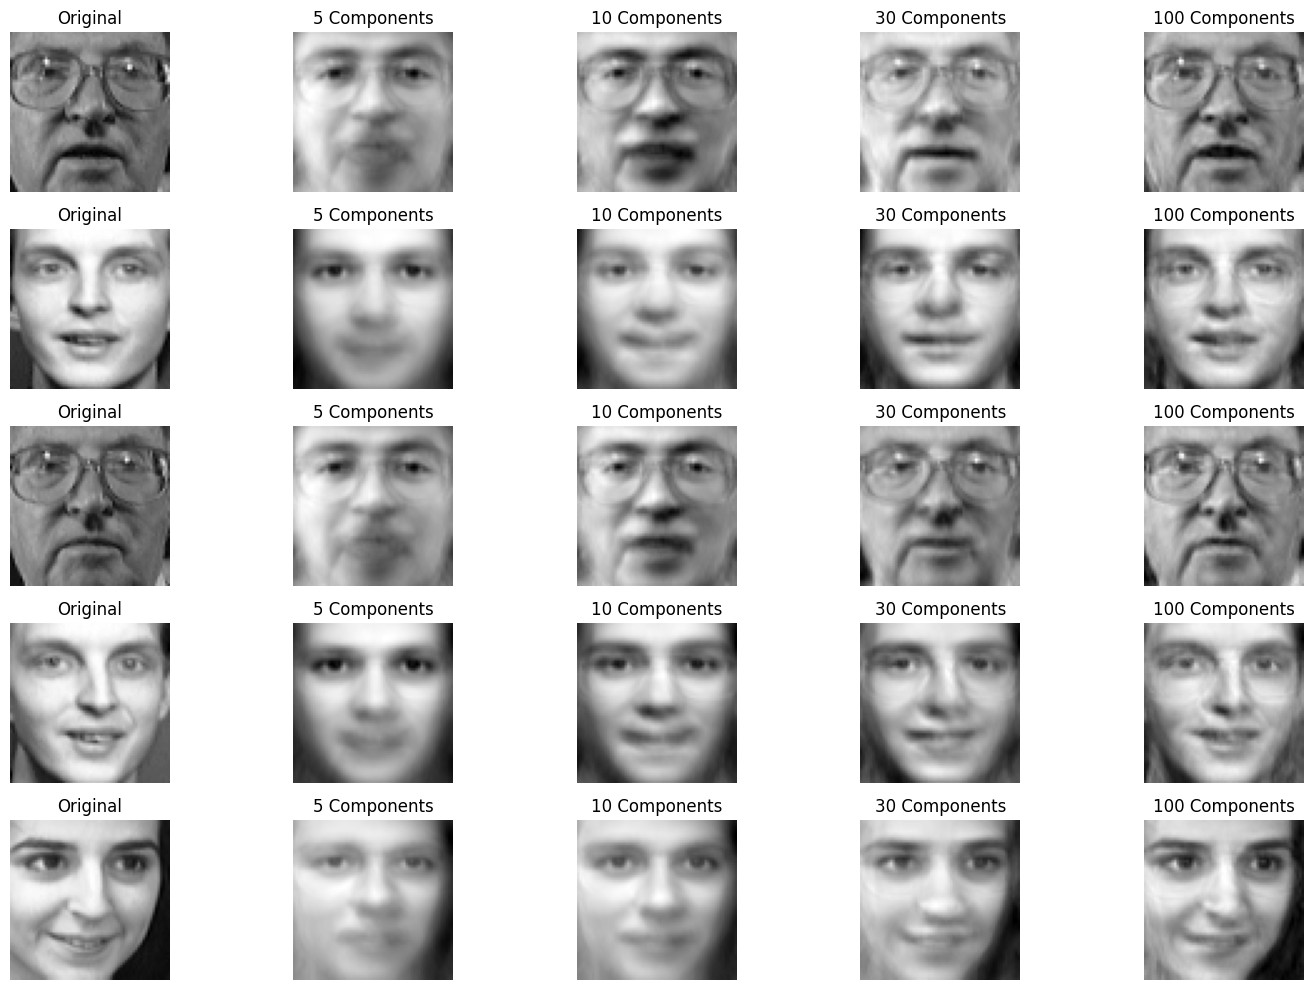

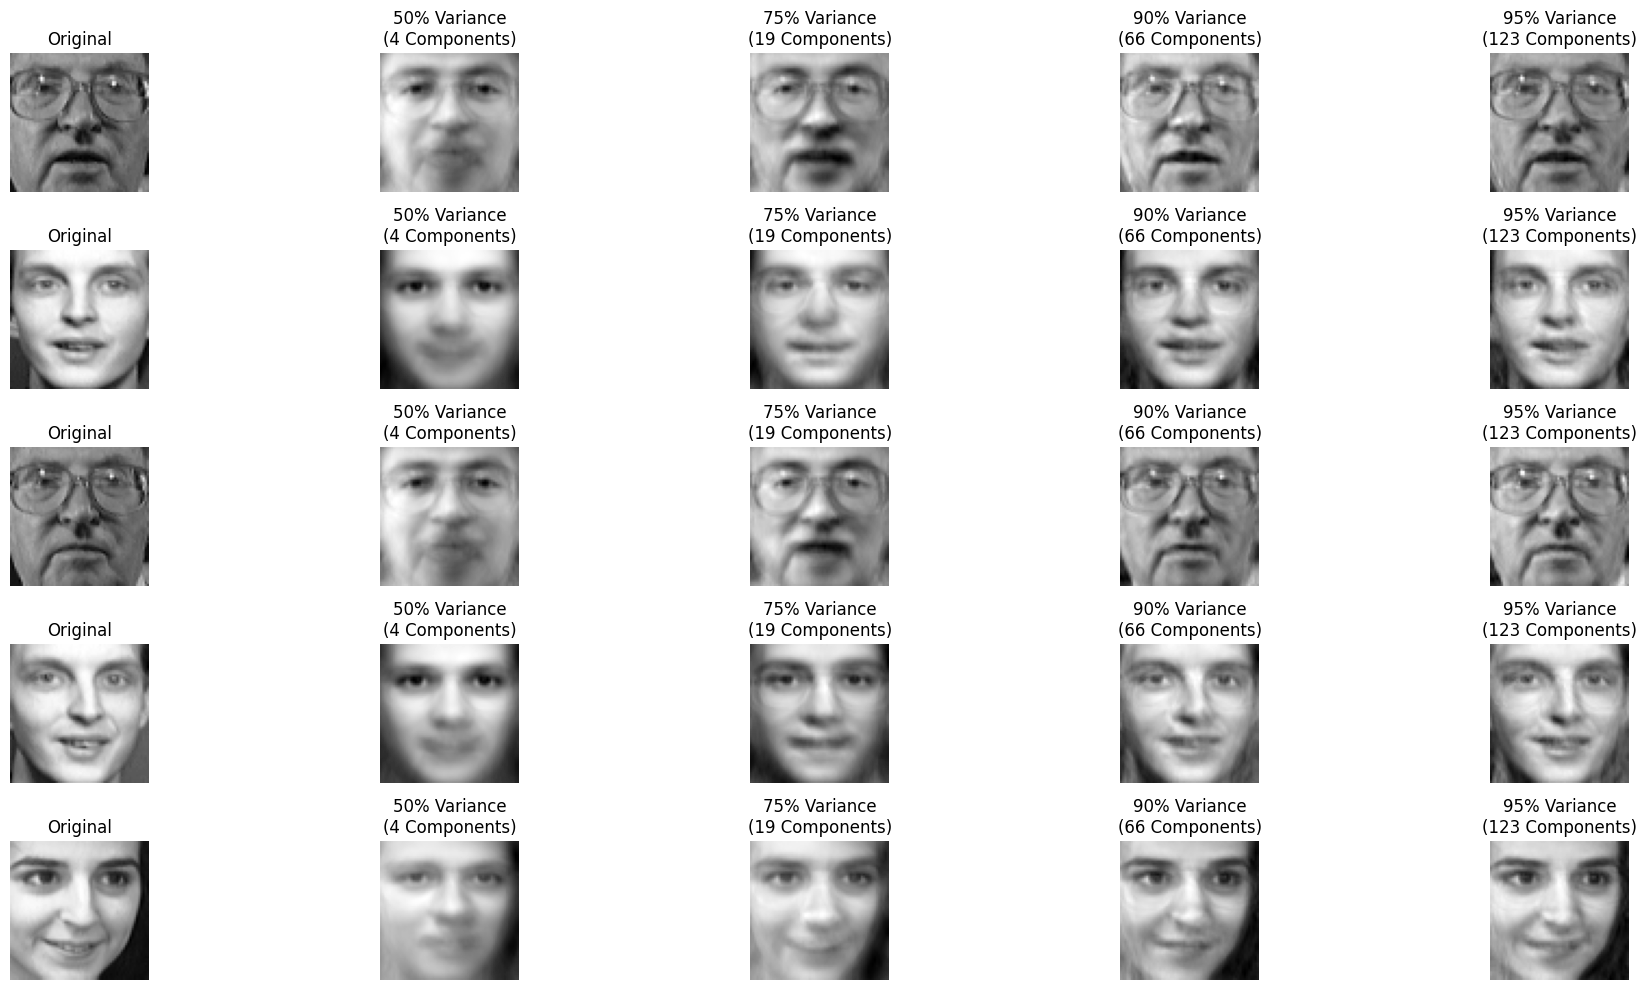

In [11]:
# Load the dataset, preprocess the images, calculate the mean face, covariance matrix, and perform eigen decomposition.
dataset_path = "olivetti_faces.npy"
images = load_olivetti_faces(dataset_path)
preprocessed_images = preprocess_images(images)
mean_face = calculate_mean_face(preprocessed_images)
covariance_matrix = calculate_covariance_matrix(preprocessed_images)
eigenvalues, eigenvectors = perform_eigen_decomposition(covariance_matrix)


# Calculate and plot the cumulative variance explained by the principal components
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()



# Define variance thresholds and component list
component_list = [5, 10, 30, 100]
variance_thresholds = [0.5, 0.75, 0.90, 0.95]

# Calculate the number of components for each variance threshold
components_for_variances = [components_for_variance(eigenvalues, vt) for vt in variance_thresholds]

# Display the number of components and corresponding variances
for threshold, components in zip(variance_thresholds, components_for_variances):
    actual_variance = cumulative_variance[components - 1]
    print(f"Variance Threshold: {threshold * 100}% - Number of Components: {components} - Actual Variance: {actual_variance * 100:.2f}%")

num_images = 5
selected_indices = random.sample(range(len(preprocessed_images)), num_images)
selected_images = preprocessed_images[selected_indices]

# Visualize reconstructed images based on component list
fig, axes = plt.subplots(num_images, len(component_list) + 1, figsize=(15, 10))
for i in range(num_images):
    axes[i, 0].imshow(selected_images[i].reshape(64, 64), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j, num_components in enumerate(component_list):
        eigenfaces = compute_eigenfaces(eigenvectors, num_components)
        centered_image = selected_images[i] - mean_face
        projection = project_images(np.array([centered_image]), eigenfaces)
        reconstructed_image = reconstruct_images(projection, eigenfaces, mean_face)
        axes[i, j+1].imshow(reconstructed_image.reshape(64, 64), cmap='gray')
        axes[i, j+1].set_title(f'{num_components} Components')
        axes[i, j+1].axis('off')
plt.tight_layout()
plt.show()

## Visualize reconstructed images based on variance thresholds
fig, axes = plt.subplots(num_images, len(variance_thresholds) + 1, figsize=(20, 10))
for i in range(num_images):
    axes[i, 0].imshow(selected_images[i].reshape(64, 64), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j, (num_components, variance_threshold) in enumerate(zip(components_for_variances, variance_thresholds)):
        eigenfaces = compute_eigenfaces(eigenvectors, num_components)
        centered_image = selected_images[i] - mean_face
        projection = project_images(np.array([centered_image]), eigenfaces)
        reconstructed_image = reconstruct_images(projection, eigenfaces, mean_face)
        axes[i, j + 1].imshow(reconstructed_image.reshape(64, 64), cmap='gray')
        axes[i, j + 1].set_title(f'{int(variance_threshold * 100)}% Variance\n({num_components} Components)')
        axes[i, j + 1].axis('off')
plt.tight_layout()
plt.show()